## In this notebook, we will produce a matrix containing all of the lightcurves in our sample (with some necessary modifications along the way) and we will implement K-Means clustering on the resultant matrix

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import pandas as pd
import os
import time
import msc_tools as mt
from sklearn import cluster

In [2]:
mast_data_path = '/Users/waderoemer/Desktop/MScThesis/MAST_data/'

### Make a histogram of the _length_ of all the light curves in our sample

In [3]:
times = [] # this will be the array of total time for each LC

for file in os.listdir(mast_data_path):
    try:
        hdu = fits.open(mast_data_path + file)
        data = hdu[1].data
        t = data['TIME'][-1] - data['TIME'][0]
        times += [t]
    except OSError: # work around the .ipynb_checkpoints and .DS_Store that come up with os.listdir()
        continue

In [4]:
print(f'''Number of LCs in sample: {len(times)}
Longest Observation: {max(times) } days 
Shortest Observation: {min(times)} days''')

Number of LCs in sample: 2589
Longest Observation: 27.833587784554084 days 
Shortest Observation: 24.437771106111995 days


Text(0.5, 0, 'Length of LC [days]')

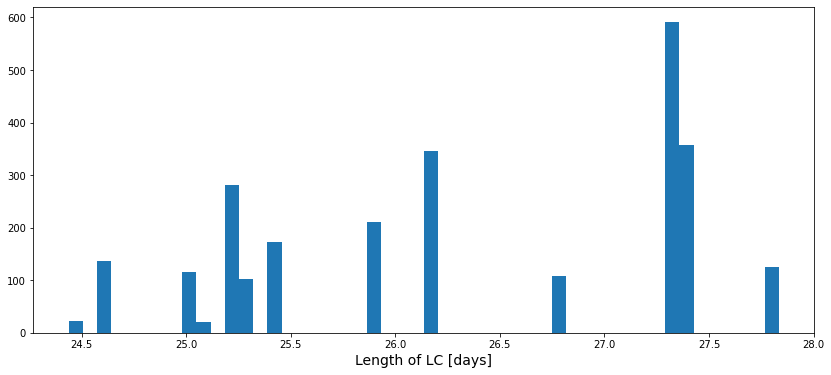

In [5]:
plt.figure(figsize = [14,6])
plt.hist(times,bins = 50)
plt.xlabel('Length of LC [days]', fontsize = 14)

### After sector 27, TESS began to observe at 10min cadence instead of 30min. So, we need to rebin any lightcurves with 10min cadence as the first step to making all of the lightcurves have the same length

In [6]:
def rebin_lc(data):
    flux = []
    i = 0
    while i <= len(data['FLUX']):
        flux_i = data['FLUX'][i][2][2] + data['FLUX'][i+1][2][2] + data['FLUX'][i+2][2][2]
        flux.append(flux_i)
        i += 3
        # if len(data['FLUX']) is not of length 3n then we have to drop the last 1-2 values
        if i+3 > len(data['FLUX']):
            break
    return flux

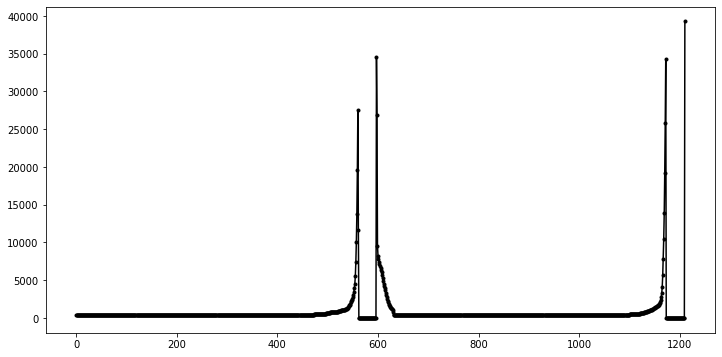

In [7]:

hdu = fits.open('MAST_data/tess-s0029-1-1_345.423250_-30.639320_5x5_astrocut.fits')
data = hdu[1].data

x = rebin_lc(data)
t = np.arange(0,len(x))
plt.figure(figsize = [12,6])
plt.plot(t,x,'k.-')

In [ ]:
## TODO: test rebinning: make a plot of the same LC before and after rebinning

### Produce a matrix of all of our light curves. The rebinning occurs within the function if the binsize < 30min. 
### Each row will correspond to the normalized light curve values, so each column will be a time bin. From the histogram produced above, we know that all of the light curves have at least 24 days of observation, so we will trim all of the light curves down to this length.

24 days of observation corresponds to :
$$
24 days \times \frac{24 hrs}{1 day} \times \frac{60 mins}{1 hr} \times \frac{1 bin}{30 mins} = 1152 bins
$$

In [41]:
## unkown issue: the min. number of bins is coming out to be 968 (~20 days)... no clue why this is happening

## will investigate further, but going to create the matrix with 968 bins for now to at least try the analysis

In [42]:
def produce_the_matrix():
    matrix = [] # this will be the array of LCs
    n_bins = 968
    
    for file in os.listdir(mast_data_path):
        try:
            hdu = fits.open(mast_data_path + file)
            data = hdu[1].data
            flux = []
            sector = hdu['PRIMARY'].header['SECTOR']
            #dt = data['TIME'][1] - data['TIME'][0]
            #if dt < (30 / (60 * 24)): # check if the binsize is < 30 mins
            if sector >= 27:
                flux = rebin_lc(data)               
                for i in range(len(flux)):
                    flux_i = flux[i]
                    flux.append(flux_i)
                flux = flux / np.max(flux) # normalize each LC
                flux = flux[:n_bins] # trim to 24 days
                matrix += [flux]
                
                
            else:         
                for i in range(len(data['FLUX'])):
                    flux_i = data['FLUX'][i][2][2] # [frame][row][col]
                    flux.append(flux_i)
                flux = flux / np.max(flux) # normalize each LC
                flux = flux[:n_bins] # trim to 24 days
                matrix += [flux]
            
        except OSError:
            continue
    
    
    return matrix

In [43]:
matrix = produce_the_matrix()

/var/folders/6q/n5vnbbxx2fb6v2txsv4jxq0r0000gn/T/ipykernel_60493/537537572.py:18: RuntimeWarning: invalid value encountered in true_divide
  flux = flux / np.max(flux) # normalize each LC
/var/folders/6q/n5vnbbxx2fb6v2txsv4jxq0r0000gn/T/ipykernel_60493/537537572.py:27: RuntimeWarning: invalid value encountered in true_divide
  flux = flux / np.max(flux) # normalize each LC


In [67]:
n_bins = 968
matrix_df = {}
for i in range(n_bins):
    col = []
    for j in range(len(matrix)):
        col.append(matrix[j][i])
    matrix_df.setdefault(f'bin_{i}', col)

matrix_df = pd.DataFrame(matrix_df)

In [113]:
#matrix_df.to_csv('TheMatrix_968_bins.csv')
print('\n\t\t\t\t\t\t*** THE MATRIX ***\n\t\t\t\t\t\t------------------')
matrix_df


						*** THE MATRIX ***
						------------------


,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,...,bin_958,bin_959,bin_960,bin_961,bin_962,bin_963,bin_964,bin_965,bin_966,bin_967
0,0.499788,0.498072,0.496276,0.496971,0.495684,0.495557,0.497951,0.494430,0.497718,0.492909,...,0.489421,0.492391,0.491975,0.491216,0.491803,0.490458,0.490742,0.488062,0.492293,0.491121
1,0.267229,0.274615,0.279207,0.284202,0.289604,0.293805,0.295526,0.300194,0.305464,0.310266,...,0.280522,0.281243,0.282227,0.282588,0.283469,0.284396,0.284537,0.286393,0.286935,0.288739
2,0.005097,0.005074,0.005105,0.005075,0.005085,0.005107,0.005110,0.005105,0.005121,0.005122,...,0.005029,0.005066,0.005053,0.005102,0.005072,0.005107,0.005076,0.005089,0.005087,0.005071
3,0.179723,0.179551,0.180770,0.180518,0.180040,0.179597,0.180611,0.179646,0.179279,0.180480,...,0.260962,0.261376,0.263229,0.264432,0.266314,0.267003,0.267488,0.268112,0.268632,0.269137
4,0.695778,0.695385,0.700574,0.692955,0.700105,0.697656,0.697976,0.698035,0.695481,0.695331,...,0.703921,0.704145,0.703890,0.703777,0.704866,0.700165,0.703577,0.702235,0.700372,0.705204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2584,0.007617,0.007641,0.007621,0.007701,0.007669,0.007652,0.007662,0.007682,0.007663,0.007637,...,0.007687,0.007664,0.007637,0.007684,0.007650,0.007680,0.007640,0.007667,0.007664,0.007660
2585,0.009525,0.009615,0.009510,0.009539,0.009506,0.009564,0.009544,0.009519,0.009538,0.009538,...,0.009456,0.009481,0.009470,0.009557,0.009469,0.009494,0.009501,0.009458,0.009511,0.009473
2586,1.000000,0.825544,0.695653,0.604698,0.539134,0.488219,0.445844,0.409053,0.376684,0.348704,...,0.016418,0.016322,0.016391,0.016298,0.016440,0.016406,0.016431,0.016389,0.016365,0.016357
2587,0.035566,0.035652,0.035748,0.035562,0.035572,0.035714,0.035526,0.035569,0.035633,0.035552,...,0.034905,0.035116,0.035191,0.035107,0.034937,0.034980,0.035076,0.034953,0.035033,0.035236


In [76]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(matrix_df, test_size=0.25, random_state=0)
n_samples, n_features = train.shape
print('n_samples:', n_samples, 'n_feautres:', n_features)

n_samples: 1941 n_feautres: 968


In [77]:
train.shape, test.shape

((1941, 968), (648, 968))

In [109]:
n_kclusters = 2
# Create the KMeans model
clf = cluster.KMeans(init='k-means++', n_clusters=n_kclusters, random_state=42)

# Cluster the full data 
clf.fit(train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [79]:
## now run k-means...
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters = 5, random_state = 0)

In [80]:
kmeans

KMeans(n_clusters=5, random_state=0)

In [ ]:
# elbow plot